In [1]:
%pylab inline

/Users/joleary/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn import svm, metrics, cross_validation
from sklearn.cross_validation import KFold
from sklearn import preprocessing
from scipy import io
from scipy import stats
import scipy.special
import numpy as np
import csv
import copy
from sklearn.feature_extraction import DictVectorizer
from functools import reduce
import time

import pickle

import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# ALL DIVISION DEFAULTS TO FLOATING POINT DIVISION
from __future__ import division

# Utility functions originally provided as MATLAB functions
def benchmark(pred_labels, true_labels):
    errors = np.not_equal(pred_labels, true_labels)
    err_rate = sum(errors) / float(len(true_labels))
    error_indices = errors.nonzero()
    return err_rate, error_indices

def montage_images(images):
    num_images=min(1000,np.size(images,2))
    numrows=math.floor(math.sqrt(num_images))
    numcols=math.ceil(num_images/numrows)
    img=np.zeros((numrows*28,numcols*28));
    for k in range(num_images):
        r = k % numrows
        c = k // numrows
        img[r*28:(r+1)*28,c*28:(c+1)*28]=images[:,:,k];
    return img

def encode_labels(labels):
    '''
    Expects: (N x 1)
    Gives you (N x 10)
    '''
    new = np.zeros((labels.shape[0], 10))
    for i in range(labels.shape[0]):
        idx = labels[i]
        new[i, idx] = 1
    return new

def decode_labels(labels):
    '''
    Expects: (N x 10)
    Gives you (N x 1)
    '''
    return np.argmax(labels, axis=1).reshape((labels.shape[0], 1))

In [155]:
data = io.loadmat('./dataset/train.mat')
X_tr = np.array(data['train_images'])
# X_tr = np.swapaxes(X_tr, 0 , 1).T
# X_tr = X_tr.reshape((60000, 784)).astype('float')
X_tr = np.array([x.reshape((784,1)) for x in np.rollaxis(X_tr, 2)])
X_tr = X_tr.reshape((60000,784)).astype('float')
y_tr = np.array(data['train_labels'])
y_tr = encode_labels(y_tr)

# Preprocessing: normalize and shuffle
# X_tr = preprocessing.normalize(X_tr, norm='l2', axis=0)
X_tr /= 255
indices = np.random.permutation(np.arange(X_tr.shape[0]))
X_tr = X_tr[indices, :]
y_tr = y_tr[indices, :]

# Split into training and validation
num_train = 50000
X_val = X_tr[num_train: , :]
y_val = y_tr[num_train: , :]
X_tr = X_tr[:num_train , :]
y_tr = y_tr[:num_train , :]

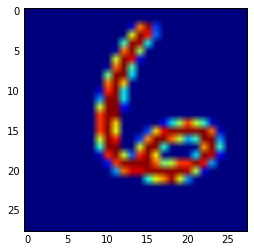

In [37]:
plt.imshow(X_tr[100].reshape((28, 28)))

In [247]:
class NeuralNetwork(object):
    
    def __init__(self, cost_fn):
        # Hyperparameters
        self.n_in = 784;
        self.n_hid = 200;
        self.n_out = 10;
        if cost_fn == "sq":
            self.cost_fn = self.sq_error
            self.cost_prime = self.sq_error_prime
        else:
            self.cost_fn = self.ce_error
            self.cost_prime = self.ce_error_prime
        
        print "Initialiing with ce error"
        
        # Plotting overhead
        self.train_time = 0 # in seconds i.e. * 100
        self.val_errs = []
        self.train_errs = []
        self.costs = []
        
        # Weights (parameters)
        # NOTE: the dimensions of weight matrices are the transpose
        # of what is listed in the spec
        # V: (n_in + 1) by n_hid
        # W: (n_hid + 1) by n_out
        
        # Maybe times 0.1
        self.V = 0.1 * np.random.randn(self.n_in +1, self.n_hid)
        self.U = 0.1 * np.random.randn(self.n_hid +1, self.n_hid)
        self.W = 0.1 * np.random.randn(self.n_hid + 1, self.n_out)
    
    def forward(self, _X):
        '''
        Performs forward propagation. Expects a single sample (row vector).
        TODO: fix how we handle bias
        Returns: class (N_samp by 1), one-out-of-10 encoded class (N_samp by 10)
        '''
        # Add input layer bias
        # if (len(_X.shape) == 1):
        #     # Deflatten if necessary
        #     X = _X.reshape((1, _X.shape[0]))
        # else:
        #     X = _X
        X = _X
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        
        # Input to hidden layer
        self.z2 = np.dot(X, self.V)
        self.a2 = self.relu(self.z2)
        
        # Add hidden layer bias
        self.a2 = np.hstack((self.a2, np.ones((self.a2.shape[0], 1))))
        
        # Hidden layer to hidden layer
        self.z3 = np.dot(self.a2, self.U)
        self.a3 = self.relu(self.z3)
        
        # Add hidden layer bias
        self.a3 = np.hstack((self.a3, np.ones((self.a3.shape[0], 1))))
        
        # Hidden layer to output
        self.z4 = np.dot(self.a3, self.W)
        self.a4 = self.relu(self.z4)
        
        # Get the predicted classes by argmaxing each row
        return self.a4
        # print self.y_hat_raw.shape
        # print (_X.shape[0], self.n_out)
    
    def predict(self, X, single_label=False):
        yHat = self.forward(X)
        if single_label:
            yHat = np.argmax(yHat, axis=1).reshape((X.shape[0], 1))
        return yHat
    
    def sq_error(self, X, y):
        '''
        Already uses weights in NeuralNetwork object
        '''
        self.yHat = self.forward(X)
        J = 0.5 * np.sum((y - self.yHat) ** 2)
        return J
    
    def sq_error_prime(self, X, y):
        '''
        Rewritten to more closely follow WelchLabs'
        '''
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW = np.dot(self.a2.T, delta3)
        
        W = self.W[:self.W.shape[0] - 1, :]
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        delta2 = np.dot(delta3, W.T) * self.tanhPrime(self.z2)
        dJdV = np.dot(X.T, delta2)  
        
        return dJdV, dJdW
    
    def train(self, X, y, eta, record_err=False, X_val=None, y_val=None):
        '''
        From the pseudocode.
        X is the entire (n x d) design matrix, not a row
        '''
        # Reset the weights
        curr_samp_idx = 0
        num_samples = X.shape[0]
        epochs_trained = 0
        start_time = time.clock() * 100
        while (epochs_trained < 20):
            if curr_samp_idx == num_samples:
                # Mod down, get error rates
                curr_samp_idx = 0
                epochs_trained +=1 
                print "TRAIN: trained {} epoch(s)".format(epochs_trained)
                print "TRAIN: train_err: {}".format(self.train_errs[-1])
                print "TRAIN: val_err: {}".format(self.val_errs[-1])
                print "TRAIN: mse cost: {}".format(self.costs[-1])
                print "\n"
                
            # Plotting overhead
            if record_err and curr_samp_idx % 1000 == 0:
                print "Iteration: {}".format(curr_samp_idx)
                # Training error
                preds = self.predict(X)
                train_err = benchmark(decode_labels(preds), decode_labels(y))[0]
                self.train_errs.append(train_err)
                # Validation error
                preds = self.predict(X_val)
                val_err = benchmark(decode_labels(preds), decode_labels(y_val))[0]
                self.val_errs.append(val_err)
                # Cost
                cost = self.cost_fn(X_tr, y_tr)
                self.costs.append(cost)
                # print "TRAIN: nn.z2: {}".format(self.z2)
                
            # Actual updating
            curr_sample = X[curr_samp_idx].reshape((1, 784))
            curr_label = y[curr_samp_idx].reshape((1, 10))
            curr_samp_idx += 1
            dJdV, dJdU, dJdW = self.cost_prime(curr_sample, curr_label)
            self.V -= eta * dJdV
            self.U -= eta * dJdU
            self.W -= eta * dJdW
            
        self.train_time += time.clock() * 100 - start_time
        return self.V, self.W
    
    def ce_error(self, X, y):
        '''
        Already uses weights in NeuralNetwork object
        NOTE: must use 1-out-of-10 encoding, not raw labels
        '''
        yHat = self.forward(X)
        eps = 1e-15
        yHat = np.clip(yHat, eps, 1.0 - eps)
        J = -np.sum(y * np.log(yHat) + (1 - y) * np.log(1 - yHat))
        return J
    
    def ce_error_prime(self, X, y):
    #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        W = self.W[:self.W.shape[0] - 1, :]
        U = self.U[:self.U.shape[0] - 1, :]
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        
        delta3 = -(y-self.yHat)
        dJdW = np.dot(self.a3.T, delta3)
        
        delta2 = np.dot(delta3, W.T) * self.reluPrime(self.z3)
        dJdU = np.dot(self.a2.T, delta2)
        
        delta1 = np.dot(delta2, U.T) * self.reluPrime(self.z2)
        dJdV = np.dot(X.T, delta1) 
        
        return dJdV, dJdU, dJdW
    
    def sigmoid(self, x):
        eps = 1e-5
        # x = np.clip(x, eps, 1.0 - eps)
        zero_indices = np.where(x == 0.0)
        x[zero_indices] = eps
        return 1/(1+np.exp(-x))
    
    def sigmoidPrime(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanhPrime(self, x):
        return 1 - (self.tanh(x) ** 2)
    
    def relu(self, x):
        zero_indices = np.where(x <= 0)
        x[zero_indices] = 0
        return x
    
    def reluPrime(self, x):
        zero_indices = np.where(x <= 0)
        one_indices = np.where(x > 0)
        x[zero_indices] = 0
        x[one_indices] = 1
        return x
    
    # Helper functions for verification
    
    def _is_correct_row(self, v, row_len):
        return v.shape == (1, row_len)
    
    #Helper Functions for interacting with other classes:
    def get_params(self):
        '''
        Get V and W unrolled into vector:
        '''
        params = np.concatenate((self.V.ravel(), self.W.ravel()))
        return params
    
    def set_params(self, params):
        '''
        Set V and W using single paramater vector.
        '''
        V_start = 0
        V_end = self.n_hid * (self.n_in + 1)
        self.V = np.reshape(params[V_start:V_end], (self.n_in + 1 , self.n_hid))
        W_end = V_end + (self.n_hid + 1)*self.n_out
        self.W = np.reshape(params[V_end:W_end], (self.n_hid + 1, self.n_out))
        
    def computeGradients(self, X, y):
        dJdV, dJdW = self.cost_prime(X, y)
        return np.concatenate((dJdV.ravel(), dJdW.ravel()))
    
    def reset_weights(self):
        self.V = np.random.randn(self.n_in +1, self.n_hid)
        self.W = np.random.randn(self.n_hid + 1, self.n_out)
    
    def reset_plotting_vals(self):
        self.val_errs = []
        self.train_errs = []
        self.costs = []

In [217]:
def computeNumericalGradient(N, X, y):
        params_initial = N.get_params()
        numgrad = np.zeros(params_initial.shape)
        perturb = np.zeros(params_initial.shape)
        e = 1e-5

        for p in range(len(params_initial)):
            if p % 10000 == 0:
                print "Num_grad: on {} of {}".format(p, len(params_initial))
            #Set perturbation vector
            perturb[p] = e
            N.set_params(params_initial + perturb)
            loss2 = N.cost_fn(X, y)
            
            N.set_params(params_initial - perturb)
            loss1 = N.cost_fn(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.set_params(params_initial)

        return numgrad

In [244]:
nn = NeuralNetwork("ce")
sample = X_tr[0].reshape((1, 784))
label = y_tr[0].reshape((1, 10))
# nn.forward(X_tr)
dJdV, dJdU, dJdB, dJdW = nn.cost_prime(sample, label)
#y_hat, y_hat_raw = nn.forward(X_tr[0])
#nn.cost(X_tr, y_tr)
#nn.tanh_prime(500)
# grad = nn.compute_gradients(X_tr[0], y_tr[0])
# preds = nn.predict(X_val)
# benchmark(preds, y_val)

Initialiing with ce error


In [248]:
eta_test = 0.01
nn = NeuralNetwork("ce")
dJdV, dJdW = None, None
for i in range(0, 50000):
    # print X_tr[i].shape
    dJdV, dJdU, dJdW = nn.cost_prime(X_tr[i].reshape((1, 784)), y_tr[i].reshape(1, 10))
    nn.V -= eta_test * dJdV
    nn.U -= eta_test * dJdU
    nn.W -= eta_test * dJdW
    if (i % 10000 == 0):
#         print nn.z2
        # print nn.forward(X_val[0].reshape((1, 784)))
        # print decode_labels(nn.a3)
        preds = nn.predict(X_val)
        print benchmark(decode_labels(preds), decode_labels(y_val))
#         print preds[:20, :]
#         print nn.y_hat_raw[:20, :]
# grad = nn.compute_gradients(X_tr[0].reshape((1, 784)), y_tr[0])
# numgrad = compute_num_grad(nn, X_tr[0].reshape((1, 784)), y_tr[0])

Initialiing with ce error
(0.90139999999999998, (array([   0,    3,    4, ..., 9996, 9997, 9998]), array([0, 0, 0, ..., 0, 0, 0])))
(0.105, (array([  21,   23,   32, ..., 9980, 9989, 9995]), array([0, 0, 0, ..., 0, 0, 0])))
(0.077399999999999997, (array([  69,   80,   86,   92,  114,  123,  131,  147,  158,  163,  164,
        173,  183,  190,  215,  236,  264,  267,  273,  300,  307,  321,
        348,  355,  367,  382,  412,  446,  479,  483,  504,  512,  520,
        531,  554,  556,  562,  594,  608,  623,  638,  657,  670,  679,
        717,  751,  755,  765,  779,  818,  820,  838,  857,  868,  897,
        901,  902,  921,  941,  944,  998, 1009, 1038, 1050, 1062, 1067,
       1095, 1098, 1114, 1140, 1146, 1189, 1197, 1198, 1244, 1249, 1263,
       1289, 1326, 1327, 1331, 1335, 1345, 1355, 1384, 1431, 1449, 1451,
       1452, 1496, 1520, 1528, 1537, 1543, 1552, 1557, 1562, 1582, 1600,
       1604, 1607, 1610, 1625, 1627, 1633, 1640, 1656, 1667, 1690, 1695,
       1758, 1762, 178

KeyboardInterrupt: 

In [109]:
sample = X_val[4].reshape((1, 784))
label = y_val[4].reshape((1, 10))
grad = nn.computeGradients(sample, label)
numgrad = computeNumericalGradient(nn, sample, label)
norm(grad-numgrad)/norm(grad+numgrad)

Num_grad: on 0 of 159010
Num_grad: on 10000 of 159010
Num_grad: on 20000 of 159010
Num_grad: on 30000 of 159010
Num_grad: on 40000 of 159010
Num_grad: on 50000 of 159010
Num_grad: on 60000 of 159010
Num_grad: on 70000 of 159010
Num_grad: on 80000 of 159010
Num_grad: on 90000 of 159010
Num_grad: on 100000 of 159010
Num_grad: on 110000 of 159010
Num_grad: on 120000 of 159010
Num_grad: on 130000 of 159010
Num_grad: on 140000 of 159010
Num_grad: on 150000 of 159010


2.0939482241544267e-10

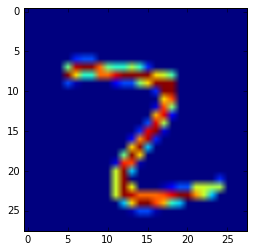

In [112]:
plt.imshow(X_tr[0].reshape((1, 784)).reshape((28, 28)))

In [31]:
nn = NeuralNetwork()
print y_tr.shape
print X_tr.shape
sample = X_tr[0].reshape((1, 784))
label = y_tr[0]
grad = nn.computeGradients(sample, label)
numgrad = computeNumericalGradient(nn, sample, label)
norm(grad-numgrad)/norm(grad+numgrad)

(50000, 1)
(50000, 784)
Num_grad: on 0 of 159010
Num_grad: on 10000 of 159010
Num_grad: on 20000 of 159010
Num_grad: on 30000 of 159010
Num_grad: on 40000 of 159010
Num_grad: on 50000 of 159010
Num_grad: on 60000 of 159010
Num_grad: on 70000 of 159010
Num_grad: on 80000 of 159010
Num_grad: on 90000 of 159010
Num_grad: on 100000 of 159010
Num_grad: on 110000 of 159010
Num_grad: on 120000 of 159010
Num_grad: on 130000 of 159010
Num_grad: on 140000 of 159010
Num_grad: on 150000 of 159010


1.9879436034831033e-09

In [39]:
grad - numgrad

array([ -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00, ...,
         1.06415426e-12,   1.48813573e-10,  -5.94221265e-12])

In [213]:
eta1 = 0.1
nn = NeuralNetwork("sq")
nn.train(X_tr, y_tr, eta1, record_err=True, X_val=X_val, y_val=y_val)

Initialiing with ce error
Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000
Iteration: 11000
Iteration: 12000
Iteration: 13000
Iteration: 14000
Iteration: 15000
Iteration: 16000
Iteration: 17000
Iteration: 18000
Iteration: 19000
Iteration: 20000
Iteration: 21000
Iteration: 22000
Iteration: 23000
Iteration: 24000
Iteration: 25000
Iteration: 26000
Iteration: 27000
Iteration: 28000
Iteration: 29000
Iteration: 30000
Iteration: 31000
Iteration: 32000
Iteration: 33000
Iteration: 34000
Iteration: 35000
Iteration: 36000
Iteration: 37000
Iteration: 38000
Iteration: 39000
Iteration: 40000
Iteration: 41000
Iteration: 42000
Iteration: 43000
Iteration: 44000
Iteration: 45000
Iteration: 46000
Iteration: 47000
Iteration: 48000
Iteration: 49000
TRAIN: trained 1 epoch(s)
TRAIN: train_err: 0.06284
TRAIN: val_err: 0.0696
TRAIN: mse cost: 2861.65874764


Iteration: 0
Iteration: 1000


(array([[ 0.02854111,  0.15273599, -0.04240936, ...,  0.10628422,
          0.06495041, -0.0777191 ],
        [-0.13130352, -0.04439366,  0.10325256, ..., -0.11873275,
         -0.01425969, -0.25010921],
        [-0.15840675,  0.0288501 ,  0.00848828, ..., -0.08931228,
          0.16707336,  0.11405496],
        ..., 
        [-0.24498135,  0.01923677,  0.00199832, ..., -0.15556783,
          0.11937946, -0.18025612],
        [-0.03904961, -0.12657371,  0.06732209, ...,  0.09273162,
         -0.09261208,  0.05240338],
        [ 0.04784493,  0.84060651, -0.21103998, ...,  0.12062873,
          0.05531938, -0.16794604]]),
 array([[ 0.31946147, -0.22043922, -0.96516179, ..., -1.17859141,
          0.66142502,  0.27778233],
        [ 0.05687263, -0.82430837,  0.38901207, ..., -0.25745878,
          0.04220999,  1.01183037],
        [ 0.7775779 , -0.06526597, -0.00768131, ..., -0.85551073,
         -1.8718326 ,  0.59483147],
        ..., 
        [ 0.42558695, -1.48682873,  0.35922368, ...,

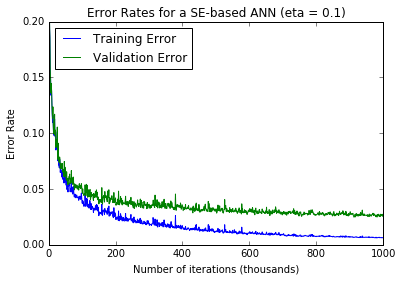

In [214]:
import matplotlib.pyplot as plt
plt_xrange = list(range(0, 1001))
# plt.plot(plt_xrange, nn.costs, label="SE Cost")
plt.plot(plt_xrange, nn.train_errs, label="Training Error")
plt.plot(plt_xrange, nn.val_errs, label="Validation Error")
plt.ylim([0.0, 0.2])
plt.legend(loc='upper left')
plt.title('Error Rates for a SE-based ANN (eta = 0.1)')
plt.xlabel('Number of iterations (thousands)')
plt.ylabel('Error Rate')
plt.show()

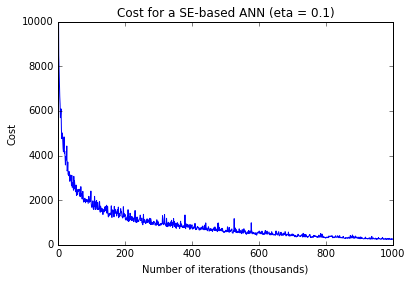

In [215]:
plt_xrange = list(range(0, 1001))
plt.plot(plt_xrange, nn.costs, label="SE Cost")
plt.ylim([0.0, 10000])
# plt.legend(loc='upper left')
plt.title('Cost for a SE-based ANN (eta = 0.1)')
plt.xlabel('Number of iterations (thousands)')
plt.ylabel('Cost')
plt.show()

In [121]:
print "took this long to train: {}".format(nn.train_time)

took this long to train: 690729.6826


In [224]:
f = open( "se_1mil_W.p", "wb" )
g = open( "se_1mil_V.p", "wb")
pickle.dump(nn.W, f)
pickle.dump(nn.V, g) 
f.close()
g.close()

In [228]:
f = open( "se_1mil_W.p", "rb" )
se_W = pickle.load(f)
se_W.shape

(201, 10)

### Load in test images

In [179]:
data_test = io.loadmat('./dataset/test.mat')
X_test = data_test['test_images']
X_test = np.swapaxes(X_test, 0 , 2).T
X_test = X_test.reshape((10000, 784)).astype('float')
X_test /= 255
X_test.shape

(10000, 784)

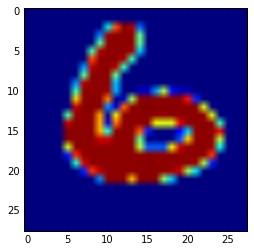

In [219]:
plt.imshow(X_test[604].reshape((28, 28)))

In [10]:
nn = NeuralNetwork()
nn.forward(X_tr[0].reshape((1, 784)))
nn.cost_fn(X_tr, y_tr)
dJdV, dJdW = nn.cost_prime(X_tr[0].reshape((1, 784)), y_tr[0].reshape((1, 10)))
dJdW

Initialiing with ce error


array([[ 0.36114242,  0.39412166,  0.2513375 , ...,  0.05200384,
         0.39530376,  0.07152323],
       [-0.50285537, -0.54877573, -0.34996279, ..., -0.07241025,
        -0.55042168, -0.09958908],
       [-0.37383294, -0.40797107, -0.26016948, ..., -0.05383125,
        -0.4091947 , -0.07403655],
       ..., 
       [ 0.19275384,  0.21035597,  0.13414727, ...,  0.0277562 ,
         0.2109869 ,  0.03817435],
       [-0.05420106, -0.05915066, -0.03772129, ..., -0.00780485,
        -0.05932807, -0.01073437],
       [ 0.52207405,  0.56974945,  0.36333806, ...,  0.0751777 ,
         0.57145831,  0.10339528]])

In [249]:
# Uses ReLUs, 2 Hidden layers
X_full = np.vstack((X_tr, X_val))
y_full = np.vstack((y_tr, y_val))
np.seterr(all='raise')
eta1 = 0.01
nn = NeuralNetwork("ce")
nn.train(X_full, y_full, eta1, record_err=True, X_val=X_val, y_val=y_val)

Initialiing with ce error
Iteration: 0
Iteration: 1000
Iteration: 2000
Iteration: 3000
Iteration: 4000
Iteration: 5000
Iteration: 6000
Iteration: 7000
Iteration: 8000
Iteration: 9000
Iteration: 10000
Iteration: 11000
Iteration: 12000
Iteration: 13000
Iteration: 14000
Iteration: 15000
Iteration: 16000
Iteration: 17000
Iteration: 18000
Iteration: 19000
Iteration: 20000
Iteration: 21000
Iteration: 22000
Iteration: 23000
Iteration: 24000
Iteration: 25000
Iteration: 26000
Iteration: 27000
Iteration: 28000
Iteration: 29000
Iteration: 30000
Iteration: 31000
Iteration: 32000
Iteration: 33000
Iteration: 34000
Iteration: 35000
Iteration: 36000
Iteration: 37000
Iteration: 38000
Iteration: 39000
Iteration: 40000
Iteration: 41000
Iteration: 42000
Iteration: 43000
Iteration: 44000
Iteration: 45000
Iteration: 46000
Iteration: 47000
Iteration: 48000
Iteration: 49000
Iteration: 50000
Iteration: 51000
Iteration: 52000
Iteration: 53000
Iteration: 54000
Iteration: 55000
Iteration: 56000
Iteration: 57000
I

KeyboardInterrupt: 

In [250]:
test_preds = nn.predict(X_test, single_label=True)

In [251]:
with open("digit_preds.csv", "w+") as file: 
    writer = csv.writer(file, lineterminator='\n')
    writer.writerow(['Id','Category'])
    for i in range(0, test_preds.shape[0]):
        writer.writerow([i + 1, test_preds[i].item()])

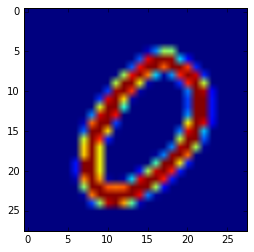

In [187]:
plt.imshow(X_test[3].reshape((28, 28)))